In [1]:
#Jalar bibliotecas que serán de utilidad para la tarea: 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from pylab import*
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import sqldf
import scipy.stats
from scipy.special import gamma
from scipy.stats import beta
from scipy.stats import spearmanr
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

In [2]:
print("Hola")

Hola


In [3]:
ruta = "./data/"
bd = "base_ini_externa.txt"
bd_ini_externa = pd.read_csv(ruta+bd,sep=" ")
bd_ini_externa.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4
0,78213,260.869565,25.854639,56.0,-230.0
1,76457,40.579710,2.872738,62.0,-230.0
2,40666,NaN,NaN,119.0,-230.0
3,8329,349.275362,34.616490,94.0,-230.0
4,68389,276.811594,27.434645,125.0,-230.0


In [4]:
bd="base_ini_interna.csv"
bd_ini_interna = pd.read_csv(ruta+bd)
bd_ini_interna.head()

,_id_,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,categoria2,categoria3
0,78213,2020-03-25,0.000000,b'0',11.0,58.0,2.0,9.0,156.0
1,76457,2020-02-13,0.000000,b'1',28.0,45.0,1.0,4.0,173.0
2,40666,2018-01-24,0.000000,b'1',25.0,45.0,1.0,9.0,170.0
3,8329,2016-10-07,0.000000,b'1',14.0,59.0,3.0,3.0,159.0
4,68389,2019-07-30,2026.342452,b'1',1.0,67.0,2.0,9.0,146.0


In [5]:
bd="base_ini_parte1.csv"
bd_ini_parte1 = pd.read_csv(ruta+bd)
bd_ini_parte1.head()

,_id_,_id2_,comp_mixto1
0,78213,1798899,0.33522
1,76457,1758511,0.33334
2,40666,935318,0.29186
3,8329,191567,0.29112
4,68389,1572947,0.27318


In [6]:
bd = "base_comportamiento_2.txt"
bd_comportamiento_2 = pd.read_csv(ruta+bd,sep=" ",low_memory=False)
bd_comportamiento_2.head()

,num_caso,mes_informacion,Tiempo_aparicion
0,1,2016-04-01 00:00:00,0.0
1,1,2016-05-01 00:00:00,1.0
2,1,2016-06-01 00:00:00,2.0
3,1,2016-07-01 00:00:00,3.0
4,1,2016-08-01 00:00:00,4.0


In [7]:
query ="""
       select num_caso as _id_,count(Tiempo_aparicion) as cantidad_tramites 
       from bd_comportamiento_2 where Tiempo_aparicion=0
       group by num_caso
       """
no_tramites=sqldf.run(query)

In [8]:
query ="""
       select num_caso as _id_,max(mes_informacion) as ultima_fecha 
       from bd_comportamiento_2
       group by num_caso
       """
ultimafecha=sqldf.run(query)

In [9]:
bdaux=bd_comportamiento_2.loc[bd_comportamiento_2['num_caso'].isin([8768 ,25022,38975 ,39026,53960 ,54384,95055])]
query=""" select num_caso,min(Tiempo_aparicion)
          from bdaux
          group by num_caso"""
bdauxiliar=sqldf.run(query)
sintesis_c2=no_tramites.merge(ultimafecha,how="right",on="_id_")
sintesis_c2=sintesis_c2.fillna(1)

In [10]:
bd = "base_comportamiento_3.csv"
bd_comportamiento_3 = pd.read_csv(ruta+bd,low_memory=False)
bd_comportamiento_3.head(10)

,num_caso,mes_informacion,comportamiento_j
0,1,2016-04-01 00:00:00,0.0
1,1,2016-05-01 00:00:00,0.0
2,1,2016-06-01 00:00:00,0.0
3,1,2016-07-01 00:00:00,0.0
4,1,2016-08-01 00:00:00,0.0
5,1,2016-09-01 00:00:00,0.0
6,1,2016-10-01 00:00:00,0.0
7,1,2016-11-01 00:00:00,0.0
8,1,2016-12-01 00:00:00,0.0
9,1,2017-01-01 00:00:00,1.0


In [11]:
query="""select num_caso as _id_,min(mes_informacion),max(mes_informacion)
         from bd_comportamiento_3
         group by num_caso"""
olvidada =sqldf.run(query)

In [12]:
query1="""select 
         num_caso,
         mes_informacion,
         comportamiento_j
         from bd_comportamiento_3
         order by num_caso,mes_informacion
         """
baseji=sqldf.run(query1).groupby("num_caso").tail(12)
baseji.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

In [13]:
query="""select 
         num_caso as _id_,         
         avg(comportamiento_j),
         max(comportamiento_j)
         from baseji
         group by num_caso
         """
sintesis_c3=sqldf.run(query)

In [14]:
query="""
     select num_caso,count(comportamiento_j),comportamiento_j
     from baseji
     group by num_caso,comportamiento_j
"""
deuda=sqldf.run(query)

In [15]:
constructo=sintesis_c3[["_id_"]]
premade="_meses_deuda"
for i in range(0,int(deuda[["comportamiento_j"]].max().iloc[0])+1):
    especifico=str(i)
    constructo.loc[:,especifico+premade]=0
constructo.head()    

C:\Users\andre\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\andre\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,_id_,0_meses_deuda,1_meses_deuda,2_meses_deuda,3_meses_deuda,4_meses_deuda,5_meses_deuda,6_meses_deuda,7_meses_deuda,8_meses_deuda,9_meses_deuda,10_meses_deuda,11_meses_deuda,12_meses_deuda,13_meses_deuda,14_meses_deuda,15_meses_deuda,16_meses_deuda,17_meses_deuda,18_meses_deuda
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
premade="_meses_deuda"
paso_anterior=0
for i in range(0,len(deuda)):
    paso_actual=deuda.iloc[i,0]
    if paso_actual==paso_anterior:
        especifico=str(int(deuda.iloc[i,2]))
        constructo.loc[vector_auxiliar,especifico+premade]=deuda.iloc[i,1]
    else:
        vector_auxiliar=(constructo["_id_"]==paso_actual)
        especifico=str(int(deuda.iloc[i,2]))
        constructo.loc[vector_auxiliar,especifico+premade]=deuda.iloc[i,1]
        paso_anterior=paso_actual  
        

In [17]:
constructo.columns=["_id_","cero_meses","uno_meses","dos_meses","tres_meses","cuatro_meses","cinco_meses","seis_meses","siete_meses","ocho_meses","nueve_meses","diez_meses","once_meses","doce_meses","trece_meses","catorce_meses","quince_meses","dseis_meses","dsiete_meses","docho_meses"]

In [18]:
query="""
        select _id_,
        cero_meses,
        uno_meses+dos_meses+tres_meses+cuatro_meses+cinco_meses+seis_meses+siete_meses+ocho_meses+nueve_meses+diez_meses+once_meses+doce_meses+trece_meses+catorce_meses+quince_meses+dseis_meses+dsiete_meses+docho_meses as uno_o_mas
        from constructo
"""
cons_aux=sqldf.run(query)

In [19]:
sintesis_c3_aux=sintesis_c3.merge(cons_aux,how="inner",on="_id_")

In [20]:
bd="base_inversion.txt"
bd_base_inversion= pd.read_csv(ruta+bd,sep=" ")
bd_base_inversion.head()

,_id2_,inversion
0,1758511,0.041039
1,1572947,77.422135
2,1051836,90.539953
3,1223255,90.205018
4,1894602,1.071354


In [21]:
bd="base_ini_parte1.csv"
bd_ini_parte1= pd.read_csv(ruta+bd)
bd_ini_parte1.head()

,_id_,_id2_,comp_mixto1
0,78213,1798899,0.33522
1,76457,1758511,0.33334
2,40666,935318,0.29186
3,8329,191567,0.29112
4,68389,1572947,0.27318


In [22]:
base_general=bd_ini_externa.merge(bd_ini_interna,how='inner',on='_id_')
base_general=base_general.sort_values('_id_')
base_general.head(10)

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,categoria2,categoria3
26635,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,b'1',26.0,67.0,3.0,3.0,171.0
20520,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,b'1',28.0,75.0,1.0,11.0,173.0
9400,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,b'1',14.0,55.0,2.0,6.0,159.0
15618,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,b'1',11.0,55.0,2.0,9.0,156.0
10561,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,b'1',11.0,56.0,2.0,6.0,156.0
6760,14,747.826087,74.116633,117.0,-230.0,2016-02-11,0.000000,b'1',19.0,68.0,4.0,3.0,164.0
38571,18,307.246377,30.451020,122.0,-230.0,2016-08-16,0.000000,b'1',14.0,50.0,2.0,5.0,159.0
10942,21,202.898551,18.672795,126.0,-230.0,2016-11-23,0.000000,b'0',14.0,75.0,2.0,9.0,159.0
42700,22,579.710145,57.454754,36.0,-230.0,2016-11-16,1317.122594,b'1',11.0,53.0,2.0,9.0,156.0
8115,24,37.681159,3.734559,131.0,-230.0,2016-06-13,0.000000,b'1',19.0,52.0,3.0,3.0,164.0


In [23]:
#Juntamos los sintesis del comportamiento2 y 3, porque tienen la misma cantidad de _id_'s
base_auxiliar=sintesis_c2.merge(sintesis_c3_aux,how='inner',on='_id_')
base_general_2=base_general.merge(base_auxiliar,how='left',on='_id_')
base_general_3=base_general_2.merge(bd_ini_parte1,how="inner",on="_id_")
base_general_4=base_general_3.merge(bd_base_inversion,how="left",on="_id2_")
base_general_4.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,categoria3,cantidad_tramites,ultima_fecha,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,_id2_,comp_mixto1,inversion
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,b'1',26.0,67.0,...,171.0,1.0,2021-05-01 00:00:00,0.083333,1.0,11.0,1.0,23,0.38000,52.500490
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,b'1',28.0,75.0,...,173.0,1.0,2018-05-01 00:00:00,0.166667,1.0,10.0,2.0,161,0.33360,0.047480
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,b'1',14.0,55.0,...,159.0,5.0,2021-04-01 00:00:00,0.083333,1.0,11.0,1.0,184,0.27898,227.537211
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,b'1',11.0,55.0,...,156.0,1.0,2017-04-01 00:00:00,0.000000,0.0,12.0,0.0,207,0.38000,0.921995
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,b'1',11.0,56.0,...,156.0,1.0,2017-05-01 00:00:00,0.083333,1.0,11.0,1.0,230,0.37050,39.259568


In [24]:
base_general_4[['comp_interno1','cero_meses','inversion']] = base_general_4[['comp_interno1','cero_meses','inversion']].fillna(value=0)
base_general_4[['max(comportamiento_j)']] = base_general_4[['max(comportamiento_j)']].fillna(value=30)
base_criterios=base_general_4[['_id_','comp_interno1', 'max(comportamiento_j)','cero_meses','inversion']].sort_values(by = '_id_')


In [25]:
base_criterios.loc[base_criterios['cero_meses']>=11,'Calif_1']=2
base_criterios.loc[(base_criterios['cero_meses']>=9) & (base_criterios['cero_meses']<=10) ,'Calif_1']=1
base_criterios.loc[base_criterios['cero_meses']<9,'Calif_1']=0

In [26]:
base_criterios.loc[base_criterios['max(comportamiento_j)']<=4,'Calif_2']=2
base_criterios.loc[(base_criterios['max(comportamiento_j)']>4) & (base_criterios['max(comportamiento_j)']<=6) ,'Calif_2']=1
base_criterios.loc[base_criterios['max(comportamiento_j)']>6,'Calif_2']=0


In [27]:
base_criterios.loc[base_criterios['inversion']>500,'Calif_3']=2
base_criterios.loc[(base_criterios['inversion']>=150) & (base_criterios['inversion']<=500) ,'Calif_3']=1
base_criterios.loc[base_criterios['inversion']<150,'Calif_3']=0

In [28]:
base_criterios.loc[base_criterios['comp_interno1']>25000,'Calif_4']=2
base_criterios.loc[(base_criterios['comp_interno1']>=3000) & (base_criterios['comp_interno1']<=25000) ,'Calif_4']=1
base_criterios.loc[base_criterios['comp_interno1']<3000,'Calif_4']=0


In [29]:
base_criterios['suma']=base_criterios['Calif_1']+base_criterios['Calif_2']+base_criterios['Calif_3']+base_criterios['Calif_4']
base_criterios.loc[base_criterios['suma']>=7,'Resultado']=np.random.binomial(1,0.99)
base_criterios.loc[base_criterios['suma']==6,'Resultado']=np.random.binomial(1,0.85)
base_criterios.loc[base_criterios['suma']==5,'Resultado']=np.random.binomial(1,0.75)
base_criterios.loc[base_criterios['suma']==4,'Resultado']=np.random.binomial(1,0.6)
base_criterios.loc[base_criterios['suma']==3,'Resultado']=np.random.binomial(1,0.4)
base_criterios.loc[base_criterios['suma']<=2,'Resultado']=np.random.binomial(1,0.1)
base_general_4['Respuesta']=base_criterios['Resultado']

In [30]:
base_general_4.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,cantidad_tramites,ultima_fecha,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,_id2_,comp_mixto1,inversion,Respuesta
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,b'1',26.0,67.0,...,1.0,2021-05-01 00:00:00,0.083333,1.0,11.0,1.0,23,0.38000,52.500490,0.0
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,b'1',28.0,75.0,...,1.0,2018-05-01 00:00:00,0.166667,1.0,10.0,2.0,161,0.33360,0.047480,1.0
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,b'1',14.0,55.0,...,5.0,2021-04-01 00:00:00,0.083333,1.0,11.0,1.0,184,0.27898,227.537211,0.0
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,b'1',11.0,55.0,...,1.0,2017-04-01 00:00:00,0.000000,0.0,12.0,0.0,207,0.38000,0.921995,0.0
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,b'1',11.0,56.0,...,1.0,2017-05-01 00:00:00,0.083333,1.0,11.0,1.0,230,0.37050,39.259568,0.0


In [31]:
ji=base_general_4["comp_interno2"]=="b'1'"
base_general_4.iloc[ji,7]=1.0
ja=base_general_4["comp_interno2"]=="b'0'"
base_general_4.iloc[ja,7]=0.0
base_general_4["comp_interno2"]=base_general_4["comp_interno2"].astype('float64')

In [32]:
base_general_4.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,cantidad_tramites,ultima_fecha,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,_id2_,comp_mixto1,inversion,Respuesta
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,1.0,26.0,67.0,...,1.0,2021-05-01 00:00:00,0.083333,1.0,11.0,1.0,23,0.38000,52.500490,0.0
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,1.0,28.0,75.0,...,1.0,2018-05-01 00:00:00,0.166667,1.0,10.0,2.0,161,0.33360,0.047480,1.0
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,1.0,14.0,55.0,...,5.0,2021-04-01 00:00:00,0.083333,1.0,11.0,1.0,184,0.27898,227.537211,0.0
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,1.0,11.0,55.0,...,1.0,2017-04-01 00:00:00,0.000000,0.0,12.0,0.0,207,0.38000,0.921995,0.0
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,1.0,11.0,56.0,...,1.0,2017-05-01 00:00:00,0.083333,1.0,11.0,1.0,230,0.37050,39.259568,0.0


In [33]:
base_general_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _id_                   50000 non-null  int64  
 1   comp_externo1          47831 non-null  float64
 2   comp_externo2          44410 non-null  float64
 3   comp_externo3          49994 non-null  float64
 4   comp_externo4          50000 non-null  float64
 5   fecha_inicio           50000 non-null  object 
 6   comp_interno1          50000 non-null  float64
 7   comp_interno2          50000 non-null  float64
 8   comp_interno3          50000 non-null  float64
 9   comp_interno4          50000 non-null  float64
 10  categoria1             50000 non-null  float64
 11  categoria2             50000 non-null  float64
 12  categoria3             50000 non-null  float64
 13  cantidad_tramites      49352 non-null  float64
 14  ultima_fecha           49352 non-null  object 
 15  av

In [34]:
#base_general_4.to_csv("Base_tarea1.csv")

# MODELO LOGÍSTICO


In [35]:
from optbinning import OptimalBinning

In [36]:
#base_general_4=pd.read_csv("C:\\Users\\andre\\Desktop\\Daniel .v\\Semestre 2022-1\\Seminario Estadística I\\Base_buena.csv")

In [37]:
#base_general_4=base_general_4.iloc[:,1:]

In [38]:
base_general_4.head()

,_id_,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,...,cantidad_tramites,ultima_fecha,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,_id2_,comp_mixto1,inversion,Respuesta
0,1,217.391304,21.545533,102.0,-230.0,2016-03-31,3039.513678,1.0,26.0,67.0,...,1.0,2021-05-01 00:00:00,0.083333,1.0,11.0,1.0,23,0.38000,52.500490,0.0
1,7,468.115942,21.674806,108.0,-230.0,2016-01-19,1547.112462,1.0,28.0,75.0,...,1.0,2018-05-01 00:00:00,0.166667,1.0,10.0,2.0,161,0.33360,0.047480,1.0
2,8,371.884058,36.857225,125.0,-230.0,2016-02-10,1215.805471,1.0,14.0,55.0,...,5.0,2021-04-01 00:00:00,0.083333,1.0,11.0,1.0,184,0.27898,227.537211,0.0
3,9,85.507246,6.274059,105.0,-230.0,2016-02-18,0.000000,1.0,11.0,55.0,...,1.0,2017-04-01 00:00:00,0.000000,0.0,12.0,0.0,207,0.38000,0.921995,0.0
4,10,72.463768,7.181844,92.0,-230.0,2016-02-18,0.000000,1.0,11.0,56.0,...,1.0,2017-05-01 00:00:00,0.083333,1.0,11.0,1.0,230,0.37050,39.259568,0.0


In [39]:
columnas=list(base_general_4.columns.values)
columnas.remove("_id_")
columnas.remove("_id2_")
print(columnas)

['comp_externo1', 'comp_externo2', 'comp_externo3', 'comp_externo4', 'fecha_inicio', 'comp_interno1', 'comp_interno2', 'comp_interno3', 'comp_interno4', 'categoria1', 'categoria2', 'categoria3', 'cantidad_tramites', 'ultima_fecha', 'avg(comportamiento_j)', 'max(comportamiento_j)', 'cero_meses', 'uno_o_mas', 'comp_mixto1', 'inversion', 'Respuesta']


In [40]:
train, test = train_test_split(base_general_4[columnas], test_size = 0.30, random_state = 100) 

In [41]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 48824 to 38408
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   comp_externo1          33480 non-null  float64
 1   comp_externo2          31123 non-null  float64
 2   comp_externo3          34996 non-null  float64
 3   comp_externo4          35000 non-null  float64
 4   fecha_inicio           35000 non-null  object 
 5   comp_interno1          35000 non-null  float64
 6   comp_interno2          35000 non-null  float64
 7   comp_interno3          35000 non-null  float64
 8   comp_interno4          35000 non-null  float64
 9   categoria1             35000 non-null  float64
 10  categoria2             35000 non-null  float64
 11  categoria3             35000 non-null  float64
 12  cantidad_tramites      34537 non-null  float64
 13  ultima_fecha           34537 non-null  object 
 14  avg(comportamiento_j)  34537 non-null  float64
 15

In [42]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 4253 to 25776
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   comp_externo1          14351 non-null  float64
 1   comp_externo2          13287 non-null  float64
 2   comp_externo3          14998 non-null  float64
 3   comp_externo4          15000 non-null  float64
 4   fecha_inicio           15000 non-null  object 
 5   comp_interno1          15000 non-null  float64
 6   comp_interno2          15000 non-null  float64
 7   comp_interno3          15000 non-null  float64
 8   comp_interno4          15000 non-null  float64
 9   categoria1             15000 non-null  float64
 10  categoria2             15000 non-null  float64
 11  categoria3             15000 non-null  float64
 12  cantidad_tramites      14815 non-null  float64
 13  ultima_fecha           14815 non-null  object 
 14  avg(comportamiento_j)  14815 non-null  float64
 15 

In [43]:
y=train.Respuesta
#y=train.credito

In [44]:
categoricas=[columnas.remove("comp_interno2"),columnas.remove("categoria1"),columnas.remove("categoria2"),columnas.remove("categoria3")]
categoricas=["comp_interno2","categoria1","categoria2","categoria3"]

categoricas

['comp_interno2', 'categoria1', 'categoria2', 'categoria3']

In [45]:
columnas

['comp_externo1',
 'comp_externo2',
 'comp_externo3',
 'comp_externo4',
 'fecha_inicio',
 'comp_interno1',
 'comp_interno3',
 'comp_interno4',
 'cantidad_tramites',
 'ultima_fecha',
 'avg(comportamiento_j)',
 'max(comportamiento_j)',
 'cero_meses',
 'uno_o_mas',
 'comp_mixto1',
 'inversion',
 'Respuesta']

In [46]:
#columnas.remove("credito")
columnas.remove("Respuesta")
#Ver qué pasa con las fechas
columnas.remove("fecha_inicio")
columnas.remove("ultima_fecha")
#columnas.remove("mes_informacion")

In [47]:
opts=[] 
denuevo=list(base_general_4.columns.values)
denuevo.remove("_id_")
denuevo.remove("_id2_")
denuevo.remove("Respuesta")
#denuevo.remove("credito")
#Por alta correlación se quitan los siguientes
#denuevo.remove("avg(comportamiento_j)")
#denuevo.remove("max(comportamiento_j)")
#denuevo.remove("uno_o_mas")
#denuevo.remove("comp_externo1")
denuevo.remove("fecha_inicio")
denuevo.remove("ultima_fecha")
#denuevo.remove("mes_informacion")
#denuevo.remove("inversion")
#denuevo.remove("comp_interno3")
for i in denuevo:
    if i in columnas:
        opts.append(OptimalBinning(name=i, dtype="numerical", solver="cp"))
    else:
        opts.append(OptimalBinning(name=i, dtype="categorical", solver="mip"))

In [48]:
for i in range(len(denuevo)):
    opts[i].fit(train[denuevo[i]],y)

In [49]:
premade="woe_"
for i in range(len(denuevo)):
    train[premade+denuevo[i]]=opts[i].transform(train[denuevo[i]], metric="woe")

In [50]:
train.head(10)


,comp_externo1,comp_externo2,comp_externo3,comp_externo4,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,...,woe_categoria1,woe_categoria2,woe_categoria3,woe_cantidad_tramites,woe_avg(comportamiento_j),woe_max(comportamiento_j),woe_cero_meses,woe_uno_o_mas,woe_comp_mixto1,woe_inversion
48824,324.637681,32.174662,127.0,-2.300000e+02,2021-03-23,0.000000,0.0,1.0,64.0,2.0,...,0.027359,-0.001057,0.008226,0.000000,0.000000,2.058127,-1.010474,0.000000,-0.011857,0.029557
2704,217.391304,21.545533,83.0,-2.300000e+02,2016-04-05,0.000000,1.0,14.0,59.0,3.0,...,-0.052638,-0.001057,-0.042091,-0.017855,2.262609,-0.518723,2.257335,1.229840,-0.008866,0.029557
25631,117.391304,NaN,130.0,-2.300000e+02,2018-07-13,0.000000,1.0,11.0,57.0,4.0,...,0.027359,-0.001057,0.019415,-0.017855,-1.445493,-0.518723,-1.010474,1.229840,-0.011857,0.029557
7285,197.101449,12.668773,129.0,-2.300000e+02,2016-08-30,0.000000,1.0,1.0,47.0,1.0,...,0.007718,-0.001057,0.008226,-0.017855,2.262609,-0.518723,2.257335,1.229840,-0.011857,0.029557
27346,217.391304,21.545533,119.0,-2.300000e+02,2018-11-06,3546.099291,0.0,16.0,49.0,1.0,...,0.007718,-0.001057,0.050051,-0.017855,-1.445493,-0.518723,-1.010474,-2.608139,-0.008866,0.029557
40815,142.608696,14.133870,131.0,-2.300000e+02,2020-06-09,0.000000,0.0,1.0,47.0,1.0,...,0.007718,-0.001057,0.008226,-0.017855,-1.445493,-0.518723,-1.010474,-2.519548,-0.011857,0.029557
22137,124.637681,5.458202,85.0,-2.300000e+02,2018-03-01,0.000000,1.0,3.0,44.0,1.0,...,0.007718,-0.001057,-0.146585,-0.017855,-1.445493,-0.518723,-1.010474,-2.519548,-0.011857,0.029557
25070,579.710145,52.887101,127.0,-2.300000e+02,2018-07-26,2026.342452,1.0,3.0,75.0,2.0,...,0.027359,-0.098493,-0.146585,-0.017855,1.085606,1.085606,-1.010474,1.229840,-0.008866,0.029557
15687,124.634783,10.054582,126.0,-2.300000e+02,2017-08-17,0.000000,0.0,19.0,49.0,3.0,...,-0.052638,-0.001057,0.019415,-0.017855,-1.445493,-0.518723,-1.010474,1.649954,0.006400,0.029557
14780,NaN,NaN,-609.0,1.000000e+10,2017-07-03,354.609929,0.0,2.0,55.0,1.0,...,0.007718,0.075976,-0.146585,-0.017855,1.085606,1.085606,2.139653,1.229840,-0.008866,0.029557


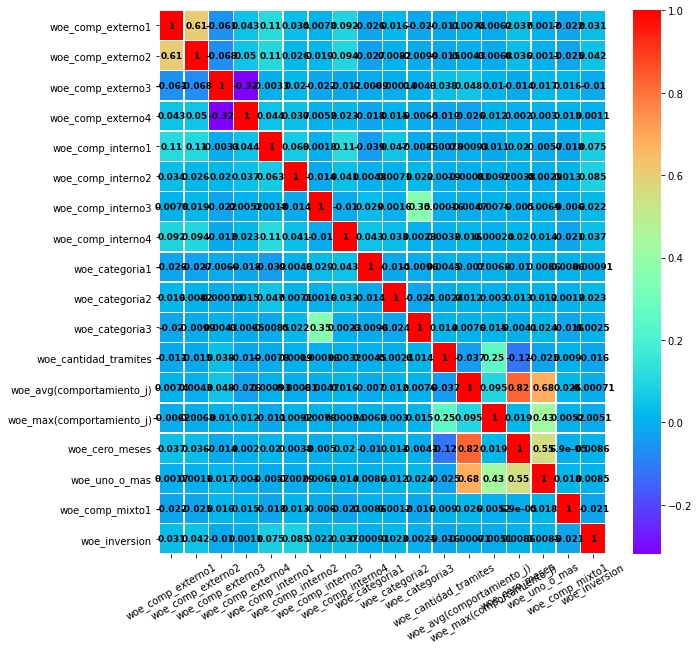

In [51]:
#corr = train.iloc[:,14:].corr()
corr = train.iloc[:,21:].corr()

xticks = list(corr.index)  
yticks = list(corr.index)  
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)

sns.heatmap(corr,annot=True,cmap="rainbow",ax=ax1,linewidths=.5,annot_kws={'size':9,'weight':'bold', 'color':'k'})
ax1.set_xticklabels(xticks, rotation=30, fontsize=10)
ax1.set_yticklabels(yticks, rotation=0, fontsize=10)
plt.show()

In [118]:
#X_woe_train=train.iloc[:,14:]
#y_train=train.iloc[:,13]
X_woe_train=train.iloc[:,21:]
y_train=train.iloc[:,20]

X_woe_train.head(10)

,woe_comp_externo1,woe_comp_externo2,woe_comp_externo3,woe_comp_externo4,woe_comp_interno1,woe_comp_interno2,woe_comp_interno3,woe_comp_interno4,woe_categoria1,woe_categoria2,woe_categoria3,woe_cantidad_tramites,woe_avg(comportamiento_j),woe_max(comportamiento_j),woe_cero_meses,woe_uno_o_mas,woe_comp_mixto1,woe_inversion
48824,0.010222,-0.038497,0.083544,-0.002858,0.022412,0.037353,-0.023341,-0.015861,0.027359,-0.001057,0.008226,0.000000,0.000000,2.058127,-1.010474,0.000000,-0.011857,0.029557
2704,0.028809,0.025691,-0.024235,-0.002858,0.022412,-0.015438,0.000624,-0.015861,-0.052638,-0.001057,-0.042091,-0.017855,2.262609,-0.518723,2.257335,1.229840,-0.008866,0.029557
25631,-0.011145,0.000000,0.056665,-0.002858,0.022412,-0.015438,0.059438,-0.015861,0.027359,-0.001057,0.019415,-0.017855,-1.445493,-0.518723,-1.010474,1.229840,-0.011857,0.029557
7285,0.028809,0.038992,0.056665,-0.002858,0.022412,-0.015438,-0.023341,0.105085,0.007718,-0.001057,0.008226,-0.017855,2.262609,-0.518723,2.257335,1.229840,-0.011857,0.029557
27346,0.028809,0.025691,0.015000,-0.002858,-0.189157,0.037353,0.000624,0.041781,0.007718,-0.001057,0.050051,-0.017855,-1.445493,-0.518723,-1.010474,-2.608139,-0.008866,0.029557
40815,-0.011145,0.038992,-0.005772,-0.002858,0.022412,0.037353,-0.023341,0.105085,0.007718,-0.001057,0.008226,-0.017855,-1.445493,-0.518723,-1.010474,-2.519548,-0.011857,0.029557
22137,-0.011145,-0.005534,-0.024235,-0.002858,0.022412,-0.015438,-0.023341,-0.002084,0.007718,-0.001057,-0.146585,-0.017855,-1.445493,-0.518723,-1.010474,-2.519548,-0.011857,0.029557
25070,-0.018701,-0.038497,0.083544,-0.002858,-0.038870,-0.015438,-0.023341,-0.034949,0.027359,-0.098493,-0.146585,-0.017855,1.085606,1.085606,-1.010474,1.229840,-0.008866,0.029557
15687,-0.011145,-0.005534,0.083544,-0.002858,0.022412,0.037353,0.000624,0.041781,-0.052638,-0.001057,0.019415,-0.017855,-1.445493,-0.518723,-1.010474,1.649954,0.006400,0.029557
14780,0.000000,0.000000,-0.043813,0.022520,0.022412,0.037353,-0.023341,-0.015861,0.007718,0.075976,-0.146585,-0.017855,1.085606,1.085606,2.139653,1.229840,-0.008866,0.029557


In [53]:
import statsmodels.api as sm
logitmodel=sm.Logit(y_train,sm.add_constant(X_woe_train)).fit()

Optimization terminated successfully.
         Current function value: 0.305668
         Iterations 11


In [54]:
print(logitmodel.summary())

                           Logit Regression Results                           
Dep. Variable:              Respuesta   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34981
Method:                           MLE   Df Model:                           18
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:                  0.4709
Time:                        19:59:18   Log-Likelihood:                -10698.
converged:                       True   LL-Null:                       -20220.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.8113      0.712     -8.164      0.000      -7.207      -4.416
woe_comp_externo1            -0.7601      0.500     -1.521      0.128      -1.740     

In [55]:
quitar=[]
nombres=X_woe_train.columns.values
for i in range(0,len(logitmodel.pvalues)-1): 
    if logitmodel.pvalues[i+1]>=0.05:
        quitar.append(nombres[i])
quitar.append("woe_uno_o_mas")        
X_woe_trainf=X_woe_train.drop(columns=quitar)        

In [56]:
X_woe_trainf.head(5)

,woe_comp_externo3,woe_comp_interno1,woe_categoria1,woe_categoria3,woe_cantidad_tramites,woe_avg(comportamiento_j),woe_max(comportamiento_j),woe_cero_meses,woe_comp_mixto1,woe_inversion
48824,0.083544,0.022412,0.027359,0.008226,0.000000,0.000000,2.058127,-1.010474,-0.011857,0.029557
2704,-0.024235,0.022412,-0.052638,-0.042091,-0.017855,2.262609,-0.518723,2.257335,-0.008866,0.029557
25631,0.056665,0.022412,0.027359,0.019415,-0.017855,-1.445493,-0.518723,-1.010474,-0.011857,0.029557
7285,0.056665,0.022412,0.007718,0.008226,-0.017855,2.262609,-0.518723,2.257335,-0.011857,0.029557
27346,0.015000,-0.189157,0.007718,0.050051,-0.017855,-1.445493,-0.518723,-1.010474,-0.008866,0.029557


Según nuestras observaciones, se puede observar que las variables:
* woe_comp_externo2
* woe_comp_externo3   
* woe_comp_externo4
* woe_comp_interno2
* woe_comp_interno3
* woe_comp_interno4
* woe_categoria1
* woe_avg(comportamiento_j)
* woe_uno_o_mas
* woe_max(comportamiento_j) (En realidad por mapa de calor xd)

En el segundo intento las que se quitan son: 
* woe_comp_mixto1
* woe_comp_interno1
* woe_comp_interno2
* woe_comp_interno3
* woe_categoria1

In [57]:
#X_woe_trainf= X_woe_train.drop(columns=["woe_comp_externo1","woe_comp_externo2","woe_comp_externo4","woe_comp_interno3","woe_categoria1","woe_categoria2","woe_categoria3","woe_avg(comportamiento_j)","woe_uno_o_mas","woe_max(comportamiento_j)","woe_comp_mixto1","woe_cantidad_tramites"])
#X_woe_trainf= X_woe_train.drop(columns=["woe_comp_externo2","woe_comp_externo3","woe_comp_externo4","woe_comp_interno2","woe_comp_interno3","woe_comp_interno4","woe_categoria1","woe_avg(comportamiento_j)","woe_uno_o_mas","woe_max(comportamiento_j)"])
#X_woe_trainf= X_woe_train.drop(columns=["woe_comp_mixto1","woe_comp_interno1","woe_comp_interno2","woe_comp_interno3","woe_categoria1","woe_mean_comportamiento_j"])

In [58]:
X_woe_trainf.head(5)

,woe_comp_externo3,woe_comp_interno1,woe_categoria1,woe_categoria3,woe_cantidad_tramites,woe_avg(comportamiento_j),woe_max(comportamiento_j),woe_cero_meses,woe_comp_mixto1,woe_inversion
48824,0.083544,0.022412,0.027359,0.008226,0.000000,0.000000,2.058127,-1.010474,-0.011857,0.029557
2704,-0.024235,0.022412,-0.052638,-0.042091,-0.017855,2.262609,-0.518723,2.257335,-0.008866,0.029557
25631,0.056665,0.022412,0.027359,0.019415,-0.017855,-1.445493,-0.518723,-1.010474,-0.011857,0.029557
7285,0.056665,0.022412,0.007718,0.008226,-0.017855,2.262609,-0.518723,2.257335,-0.011857,0.029557
27346,0.015000,-0.189157,0.007718,0.050051,-0.017855,-1.445493,-0.518723,-1.010474,-0.008866,0.029557


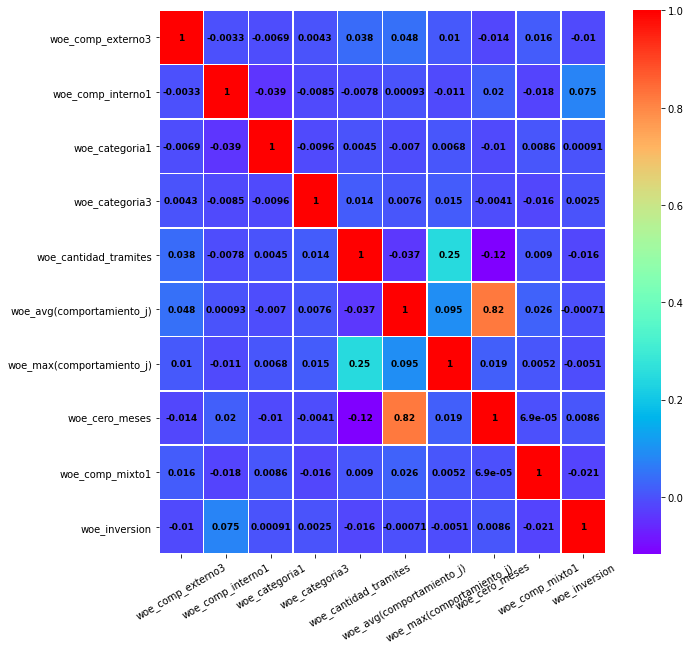

In [59]:
corr = X_woe_trainf.corr()


xticks = list(corr.index)  
yticks = list(corr.index)  
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)

sns.heatmap(corr,annot=True,cmap="rainbow",ax=ax1,linewidths=.5,annot_kws={'size':9,'weight':'bold', 'color':'k'})
ax1.set_xticklabels(xticks, rotation=30, fontsize=10)
ax1.set_yticklabels(yticks, rotation=0, fontsize=10)
plt.show()

In [60]:
y_train.head(20)

48824    0.0
2704     0.0
25631    1.0
7285     0.0
27346    0.0
40815    1.0
22137    1.0
25070    1.0
15687    0.0
14780    0.0
29571    0.0
42308    0.0
44083    0.0
27287    1.0
41101    1.0
10361    0.0
4824     0.0
36601    0.0
32958    0.0
44982    0.0
Name: Respuesta, dtype: float64

In [ ]:
y_trainw=y_train

In [134]:
model=LogisticRegression()
clf=model.fit(X_woe_trainf,y_trainw)

In [135]:
y_pred=clf.predict(X_woe_trainf)
y_pred1=clf.decision_function(X_woe_trainf)
print('y_pred\n',y_pred)
print('y_pred1\n',y_pred1)

#Draw ROC curve and calculate AUC value
fpr,tpr,threshold = roc_curve(y_train, y_pred)
roc_auc = auc(fpr,tpr)
plot(fpr,tpr,color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()

y_pred
 [0. 0. 1. ... 1. 1. 0.]
y_pred1
 [-2.23907719 -2.80928449  0.53642656 ...  0.52627282  0.71464864
 -1.48018935]


ValueError: Found input variables with inconsistent numbers of samples: [40000, 35000]

In [63]:
ks_2samp(y_train,y_pred)

KstestResult(statistic=0.05697142857142856, pvalue=8.188398239538498e-50)

In [64]:
coe=model.coef_
coe[0]

array([-0.93581077, -1.12763055, -1.55713878, -1.16950092, -0.98029324,
       -0.21370279, -0.94573902, -0.86347719, -1.27287358, -1.7542591 ])

In [65]:
premade="woe_"
for i in range(len(denuevo)):
    test[premade+denuevo[i]]=opts[i].transform(test[denuevo[i]], metric="woe")

In [66]:
X_woe_test=test.iloc[:,21:]
y_test=test.iloc[:,20]
#X_woe_test=test.iloc[:,14:]
#y_test=test.iloc[:,13]

In [67]:
quitar=[]
nombres=X_woe_train.columns.values
for i in range(0,len(logitmodel.pvalues)-1): 
    if logitmodel.pvalues[i+1]>=0.05:
        quitar.append(nombres[i])
quitar.append("woe_uno_o_mas")        
X_woe_testf=X_woe_test.drop(columns=quitar)        

In [68]:
#X_woe_testf= X_woe_test.drop(columns=["woe_comp_externo1","woe_comp_externo2","woe_comp_externo4","woe_comp_interno3","woe_categoria1","woe_categoria2","woe_categoria3","woe_avg(comportamiento_j)","woe_uno_o_mas","woe_max(comportamiento_j)","woe_comp_mixto1","woe_cantidad_tramites"])
#X_woe_testf= X_woe_test.drop(columns=["woe_comp_externo2","woe_comp_externo3","woe_comp_externo4","woe_comp_interno2","woe_comp_interno3","woe_comp_interno4","woe_categoria1","woe_avg(comportamiento_j)","woe_uno_o_mas","woe_max(comportamiento_j)"])
#X_woe_testf= X_woe_test.drop(columns=["woe_comp_mixto1","woe_comp_interno1","woe_comp_interno2","woe_comp_interno3","woe_categoria1","woe_mean_comportamiento_j"])

y_pred
 [0. 0. 0. ... 0. 0. 1.]
y_pred1
 [-2.92951536 -4.17239559 -1.52738364 ... -4.22299459 -1.78459962
  0.96384428]


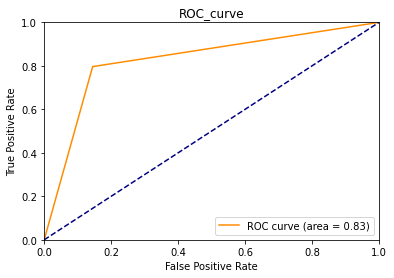

In [69]:
y_pred=clf.predict(X_woe_testf)
y_pred1=clf.decision_function(X_woe_testf)
print('y_pred\n',y_pred)
print('y_pred1\n',y_pred1)

#Draw ROC curve and calculate AUC value
fpr,tpr,threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)
plot(fpr,tpr,color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()

In [71]:
ks_2samp(y_test,y_pred)

KstestResult(statistic=0.05300000000000005, pvalue=9.457505512441484e-19)

# ÁRBOL

In [72]:
def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

#         print('#######################')
#         print('Evaluation metrics ####')
#         print('#######################')
#         print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}')
#         print(f'Precision: {metrics.precision_score(y_test, y_pred):.4f}')
#         print(f'Recall (Sensitivity): {metrics.recall_score(y_test, y_pred):.4f}')
#         print(f'Specificity: {(tn / (tn + fp)):.4f}')
#         print(f'F1-Score: {metrics.f1_score(y_test, y_pred):.4f}')
#         print(f"Cohen's Kappa: {metrics.cohen_kappa_score(y_test, y_pred):.4f}")

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

In [73]:
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)

In [74]:
newbase=base_general_4
X = newbase.drop(['_id_', '_id2_','fecha_inicio','ultima_fecha'], axis=1)
X.head()

,comp_externo1,comp_externo2,comp_externo3,comp_externo4,comp_interno1,comp_interno2,comp_interno3,comp_interno4,categoria1,categoria2,categoria3,cantidad_tramites,avg(comportamiento_j),max(comportamiento_j),cero_meses,uno_o_mas,comp_mixto1,inversion,Respuesta
0,217.391304,21.545533,102.0,-230.0,3039.513678,1.0,26.0,67.0,3.0,3.0,171.0,1.0,0.083333,1.0,11.0,1.0,0.38000,52.500490,0.0
1,468.115942,21.674806,108.0,-230.0,1547.112462,1.0,28.0,75.0,1.0,11.0,173.0,1.0,0.166667,1.0,10.0,2.0,0.33360,0.047480,1.0
2,371.884058,36.857225,125.0,-230.0,1215.805471,1.0,14.0,55.0,2.0,6.0,159.0,5.0,0.083333,1.0,11.0,1.0,0.27898,227.537211,0.0
3,85.507246,6.274059,105.0,-230.0,0.000000,1.0,11.0,55.0,2.0,9.0,156.0,1.0,0.000000,0.0,12.0,0.0,0.38000,0.921995,0.0
4,72.463768,7.181844,92.0,-230.0,0.000000,1.0,11.0,56.0,2.0,6.0,156.0,1.0,0.083333,1.0,11.0,1.0,0.37050,39.259568,0.0


In [75]:
y = X.pop('Respuesta')

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y)

In [77]:
num_features = X_train.select_dtypes(include='number').columns.to_list()
num_features

['comp_externo1',
 'comp_externo2',
 'comp_externo3',
 'comp_externo4',
 'comp_interno1',
 'comp_interno2',
 'comp_interno3',
 'comp_interno4',
 'categoria1',
 'categoria2',
 'categoria3',
 'cantidad_tramites',
 'avg(comportamiento_j)',
 'max(comportamiento_j)',
 'cero_meses',
 'uno_o_mas',
 'comp_mixto1',
 'inversion']

In [78]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   comp_externo1          47831 non-null  float64
 1   comp_externo2          44410 non-null  float64
 2   comp_externo3          49994 non-null  float64
 3   comp_externo4          50000 non-null  float64
 4   comp_interno1          50000 non-null  float64
 5   comp_interno2          50000 non-null  float64
 6   comp_interno3          50000 non-null  float64
 7   comp_interno4          50000 non-null  float64
 8   categoria1             50000 non-null  float64
 9   categoria2             50000 non-null  float64
 10  categoria3             50000 non-null  float64
 11  cantidad_tramites      49352 non-null  float64
 12  avg(comportamiento_j)  49352 non-null  float64
 13  max(comportamiento_j)  50000 non-null  float64
 14  cero_meses             50000 non-null  float64
 15  un

In [79]:
cat_features = X_train.select_dtypes(include='object').columns.to_list()
cat_features

[]

In [80]:
num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

In [81]:
cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]

In [82]:
cat_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                               ('onehot', OneHotEncoder(categories=cat_list, sparse=False,
                                        handle_unknown='error', drop='first'))])

In [83]:
preprocessor = ColumnTransformer(transformers=[
               ('numerical', num_pipeline, num_features),
               ('categorical', cat_pipeline, cat_features)],
               remainder='drop')
#El remainder=drop es para eliminar la columna que no se le aplicó ninguna transformación

In [84]:
dec_tree = DecisionTreeClassifier(random_state=42)

In [85]:
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', dec_tree)])

In [86]:
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['comp_externo1',
                                                   'comp_externo2',
                                                   'comp_externo3',
                                                   'comp_externo4',
                                                   'comp_interno1',
                                                   'comp_interno2',
                                                   'comp_interno3',
                                                   'comp_interno4',
                                                   'categoria1', 'categoria2',
                                                   'categoria3',
                                  

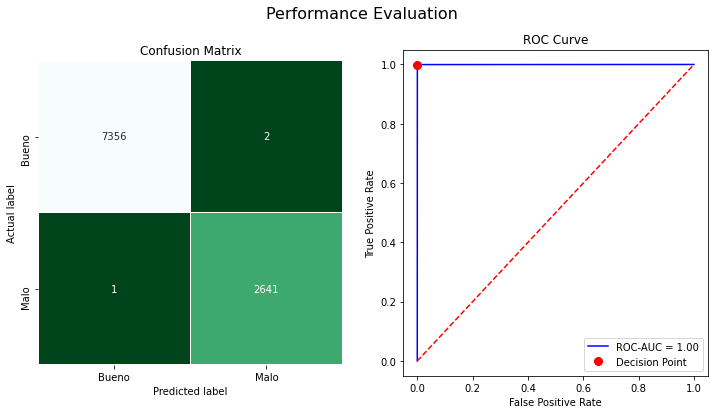

In [87]:
LABELS = ['Bueno', 'Malo']
tree_perf = performance_evaluation_report(tree_pipeline, X_test,y_test, labels=LABELS,show_plot=True)

In [88]:
#eliminacion de outliers


In [89]:
from sklearn.base import BaseEstimator, TransformerMixin

In [90]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y = None):
        if np.isnan(X).any(axis=None):
            raise ValueError('''There are missing values in the array! 
                                Please remove them.''')

        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        
        self.upper_band_ = mean_vec + self.n_std * std_vec
        self.lower_band_ = mean_vec - self.n_std * std_vec
        self.n_features_ = len(self.upper_band_)
        
        return self 
    
    def transform(self, X, y = None):
        X_copy = pd.DataFrame(X.copy())
        
        upper_band = np.repeat(
            self.upper_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        lower_band = np.repeat(
            self.lower_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        
        return X_copy.values

In [91]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutlierRemover())])

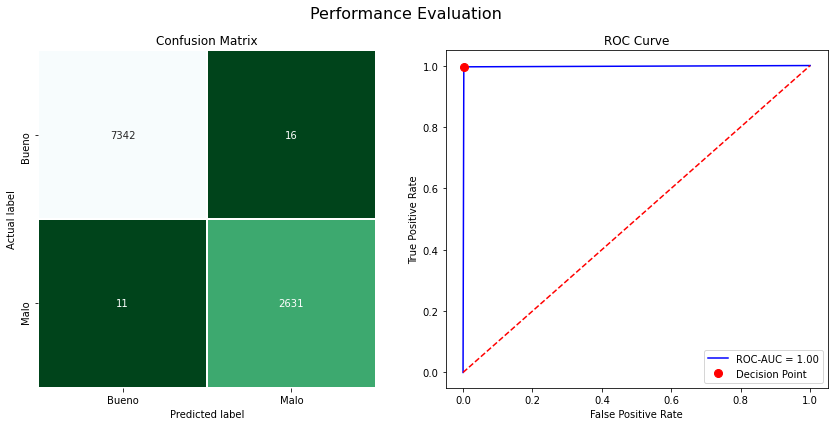

In [92]:
preprocessor = ColumnTransformer(transformers=[('numerical', num_pipeline, num_features),
                                               ('categorical', cat_pipeline, cat_features)],
                                 remainder='drop')

dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', dec_tree)])

tree_pipeline.fit(X_train, y_train)

tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im18.png')
plt.show()

In [93]:
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)

In [94]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

In [95]:
cross_val_score(tree_pipeline, X_train, y_train, cv=k_fold)

array([0.99575 , 0.997875, 0.9975  , 0.996625, 0.996125])

In [96]:
cross_validate(tree_pipeline, X_train, y_train, cv=k_fold,
                           scoring=['accuracy', 'precision', 'recall','roc_auc'])

{'fit_time': array([1.00742006, 1.02041292, 1.02241373, 0.97243857, 1.03740621]),
 'score_time': array([0.26185298, 0.22487497, 0.23586583, 0.2838378 , 0.2348671 ]),
 'test_accuracy': array([0.99575 , 0.997875, 0.9975  , 0.996625, 0.996125]),
 'test_precision': array([0.99148936, 0.99668246, 0.99479905, 0.99431549, 0.99336807]),
 'test_recall': array([0.99242783, 0.99526739, 0.99574065, 0.99290445, 0.99195837]),
 'test_roc_auc': array([0.99468512, 0.99703917, 0.99693606, 0.99543286, 0.99478992])}

In [97]:
param_grid = {'classifier__criterion': ['entropy', 'gini'],
               'classifier__max_depth': range(3, 11),
               'classifier__min_samples_leaf': range(2, 11)}


In [98]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid,scoring='recall',cv=k_fold, n_jobs=-1, verbose=1)
classifier_gs.fit(X_train, y_train)
#print(f'Best parameters: {classifier_gs.best_params_}')
#print(f'Recall (Training set): {classifier_gs.best_score_:.4f}')
#print(f'Recall (Test set): {metrics.recall_score(y_test,classifier_gs.predict(X_test)):.4f}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 10.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('outliers',
                                                                                          OutlierRemover())]),
                                                                         ['comp_externo1',
                                                                          'comp_externo2',
                                                                          'comp_externo3',
                                                                      

In [99]:
print(f'Best parameters: {classifier_gs.best_params_}')
print(f'Recall (Training set): {classifier_gs.best_score_:.4f}')
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_gs.predict(X_test)):.4f}')

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 6, 'classifier__min_samples_leaf': 2}
Recall (Training set): 0.9956
Recall (Test set): 0.9977


In [100]:
clasificador=classifier_gs.best_params_['classifier__criterion']
profundidad=classifier_gs.best_params_['classifier__max_depth']
minhojas=classifier_gs.best_params_['classifier__min_samples_leaf']

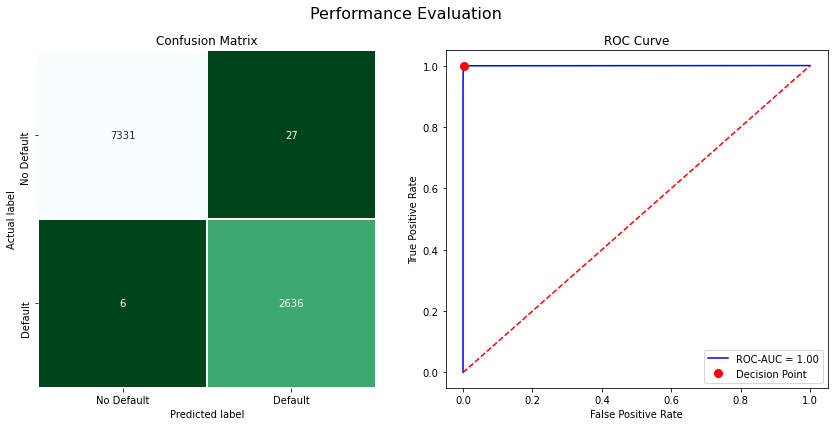

In [101]:
LABELS = ['No Default', 'Default']
tree_gs_perf = performance_evaluation_report(classifier_gs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

plt.tight_layout()
#plt.savefig('images/ch8_im20.png')
plt.show()

In [102]:
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve,  accuracy_score

In [103]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in range(1, 26):
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeClassifier(criterion=clasificador,
                                          max_depth=max_depth,
                                          min_samples_leaf=10,
                                          random_state=42)
    tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', reg_tree)])
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [],[], []
    for train_idx, test_idx in k_fold.split(X_train,y_train):
        X_t, y_t,  = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_te, y_te = X_train.iloc[test_idx], y_train.iloc[test_idx]
        tree_pipeline.fit(X_t, y_t)
        train_pred = tree_pipeline.predict_proba(X=X_t)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_t)
        #print(train_score)
        train_scores[max_depth].append(train_score)

        test_pred = tree_pipeline.predict_proba(X=X_te)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_te)
        val_scores[max_depth].append(val_score)  
        #print(val_score)
        leaves[max_depth].append(max_depth)
        #reg_tree.fit(X=X_t, y=y_t)

        
        #train_scores[max_depth].append(train_score)

        #test_pred = reg_tree.predict(X=X_test)
        #val_score = np.sqrt(mean_squared_error(
        #    y_pred=test_pred, y_true=y_test))
        #val_scores[max_depth].append(val_score)
        #leaves[max_depth].append(get_leaves_count(reg_tree))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

In [104]:
clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
bd_leaves = pd.DataFrame(leaves)

In [105]:
leaves

{1: [1, 1, 1, 1, 1],
 2: [2, 2, 2, 2, 2],
 3: [3, 3, 3, 3, 3],
 4: [4, 4, 4, 4, 4],
 5: [5, 5, 5, 5, 5],
 6: [6, 6, 6, 6, 6],
 7: [7, 7, 7, 7, 7],
 8: [8, 8, 8, 8, 8],
 9: [9, 9, 9, 9, 9],
 10: [10, 10, 10, 10, 10],
 11: [11, 11, 11, 11, 11],
 12: [12, 12, 12, 12, 12],
 13: [13, 13, 13, 13, 13],
 14: [14, 14, 14, 14, 14],
 15: [15, 15, 15, 15, 15],
 16: [16, 16, 16, 16, 16],
 17: [17, 17, 17, 17, 17],
 18: [18, 18, 18, 18, 18],
 19: [19, 19, 19, 19, 19],
 20: [20, 20, 20, 20, 20],
 21: [21, 21, 21, 21, 21],
 22: [22, 22, 22, 22, 22],
 23: [23, 23, 23, 23, 23],
 24: [24, 24, 24, 24, 24],
 25: [25, 25, 25, 25, 25]}

In [106]:
clf_train_scores

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,0.812929,0.913025,0.967667,0.994906,0.999738,0.999967,0.999983,0.999985,0.999985,0.999985,...,0.999985,0.999985,0.999985,0.999985,0.999985,0.999985,0.999985,0.999985,0.999985,0.999985
1,0.811170,0.911671,0.967360,0.994971,0.999679,0.999951,0.999979,0.999981,0.999982,0.999982,...,0.999982,0.999982,0.999982,0.999982,0.999982,0.999982,0.999982,0.999982,0.999982,0.999982
2,0.811429,0.912392,0.967946,0.994810,0.999661,0.999951,0.999980,0.999982,0.999983,0.999983,...,0.999983,0.999983,0.999983,0.999983,0.999983,0.999983,0.999983,0.999983,0.999983,0.999983
3,0.815285,0.912029,0.967271,0.994591,0.999631,0.999956,0.999975,0.999983,0.999984,0.999984,...,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984
4,0.810593,0.910807,0.967301,0.994616,0.999641,0.999959,0.999977,0.999980,0.999980,0.999980,...,0.999980,0.999980,0.999980,0.999980,0.999980,0.999980,0.999980,0.999980,0.999980,0.999980


In [107]:
clf_valid_scores

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,0.809689,0.908470,0.967044,0.993997,0.998711,0.999135,0.997978,0.997978,0.997978,0.997978,...,0.997978,0.997978,0.997978,0.997978,0.997978,0.997978,0.997978,0.997978,0.997978,0.997978
1,0.816727,0.913861,0.968431,0.994237,0.999372,0.999242,0.999185,0.999101,0.999100,0.999100,...,0.999100,0.999100,0.999100,0.999100,0.999100,0.999100,0.999100,0.999100,0.999100,0.999100
2,0.815690,0.910785,0.965899,0.994950,0.999501,0.999519,0.999117,0.999135,0.999134,0.999134,...,0.999134,0.999134,0.999134,0.999134,0.999134,0.999134,0.999134,0.999134,0.999134,0.999134
3,0.800268,0.906898,0.965181,0.992762,0.999229,0.999809,0.999676,0.999606,0.999203,0.999203,...,0.999203,0.999203,0.999203,0.999203,0.999203,0.999203,0.999203,0.999203,0.999203,0.999203
4,0.819034,0.916443,0.968057,0.995174,0.999110,0.999295,0.998380,0.998301,0.998301,0.998301,...,0.998301,0.998301,0.998301,0.998301,0.998301,0.998301,0.998301,0.998301,0.998301,0.998301


In [108]:
roc_entrenamiento=[]
for c in clf_train_scores.columns:
    promedio_roc=mean(clf_train_scores[c])
    roc_entrenamiento.append(promedio_roc)
    
roc_validacion=[]
for c in clf_valid_scores.columns:
    promedio_roc=mean(clf_valid_scores[c])
    roc_validacion.append(promedio_roc)

prof=[]
for c in bd_leaves.columns:
    id_=mean(bd_leaves[c])
    prof.append(id_)

In [109]:
roc_entrenamiento

[0.8122812858550057,
 0.9119849019033367,
 0.9675092452049313,
 0.9947788720612655,
 0.9996700251319381,
 0.9999567710741999,
 0.9999786868742996,
 0.9999822508299501,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049,
 0.9999826708284049]

In [110]:
roc_validacion

[0.812281625325889,
 0.9112912130344901,
 0.9669224229797129,
 0.9942240001412024,
 0.9991847047025315,
 0.9994000413816636,
 0.9988670013120083,
 0.9988241780746889,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849,
 0.9987431685832849]

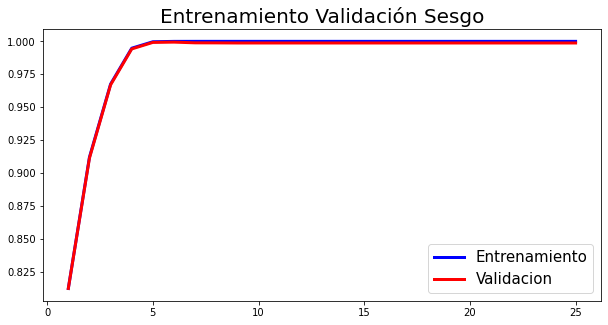

In [111]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title("Entrenamiento Validación Sesgo",fontsize=20)
ax.plot(prof,roc_entrenamiento,color="blue",linewidth=3,label="Entrenamiento")
ax.plot(prof,roc_validacion,color="red",linewidth=3,label="Validacion")
#gca().yaxis.set_major_formatter("{x:,.0%}")
#xticks(fontsize=16)
#yticks(fontsize=16)
#axvline(4)
legend(fontsize=15)
show()

In [112]:
reg_tree = DecisionTreeClassifier(criterion=clasificador,
                                          max_depth=profundidad,
                                          min_samples_leaf=minhojas,
                                          random_state=42)
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', reg_tree)])

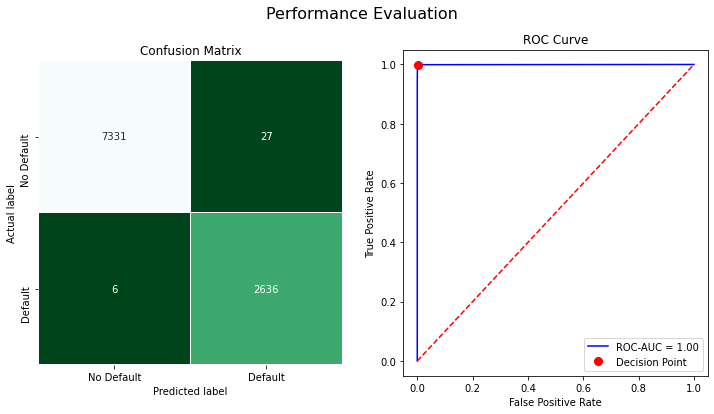

In [113]:
tree_pipeline.fit(X_train, y_train)

tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

In [132]:
mean(cross_validate(tree_pipeline, X_train, y_train, cv=k_fold,
                           scoring=['accuracy', 'precision', 'recall','roc_auc'])['test_roc_auc'])

0.9993758069796069

In [137]:
cross_validate(model, X_woe_trainf, y_trainw, cv=k_fold,
                           scoring=['accuracy', 'precision', 'recall','roc_auc'])

C:\Users\andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\andre\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\andre\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\andre\anaconda3\lib\site-packages\joblib\parallel.py", line 784, in _dispatch
    job = self._backend.apply_async(batch,

{'fit_time': array([0.83152223, 0.73457932, 0.99643016, 1.13535786, 1.16133642]),
 'score_time': array([0.05996847, 0.0809536 , 0.0819509 , 0.        , 0.        ]),
 'test_accuracy': array([0.84557143, 0.83885714, 0.84242857,        nan,        nan]),
 'test_precision': array([0.67249104, 0.66016837, 0.66191094,        nan,        nan]),
 'test_recall': array([0.81091302, 0.80497029, 0.82667387,        nan,        nan]),
 'test_roc_auc': array([0.88464808, 0.88458234, 0.88455397,        nan,        nan])}

In [130]:
len(y_train)

40000

In [131]:
len(y_trainw)

35000